# PageRank Performance Benchmarking

This notebook benchmarks performance of running PageRank within cuGraph against NetworkX. NetworkX contains several implementations of PageRank.  This benchmark will compare cuGraph versus the defaukt Nx implementation as well as the SciPy version

Notebook Credits

    Original Authors: Bradley Rees
    Last Edit: 10/30/2019
    
RAPIDS Versions: 0.10.0

Test Hardware

    GV100 32G, CUDA 10,0
    Intel(R) Core(TM) CPU i7-7800X @ 3.50GHz
    32GB system memory
    


### Test Data

| File Name              | Num of Vertices | Num of Edges |
|:---------------------- | --------------: | -----------: |
| preferentialAttachment |         100,000 |      999,970 |
| caidaRouterLevel       |         192,244 |    1,218,132 |
| coAuthorsDBLP          |         299,067 |    1,955,352 |
| dblp-2010              |         326,186 |    1,615,400 |
| citationCiteseer       |         268,495 |    2,313,294 |
| coPapersDBLP           |         540,486 |   30,491,458 |
| coPapersCiteseer       |         434,102 |   32,073,440 |
| as-Skitter             |       1,696,415 |   22,190,596 |




### Timing 
What is not timed:  Reading the data
What is timmed: (1) creating a Graph, (2) running PageRank

The data file is read in once for all flavors of PageRank.  Each timed block will craete a Graph and then execute the algorithm.  The results of the algorithm are not compared.  If you are interested in seeing the comparison of results, then please see PageRank in the __notebooks__ repo. 

## NOTICE
You must have run the dataPrep script prior to running this notebook so that the data is downloaded

See the README file in this folder for a discription of how to get the data

In [1]:
# Import needed libraries
import time
import cugraph
import cudf

In [2]:
# NetworkX libraries
import networkx as nx
from scipy.io import mmread

In [3]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

### Define the test data

In [4]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

### Define the testing functions

In [5]:
# Data reader - the file format is MTX, so we will use the reader from SciPy
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    M = mmread(mm_file).asfptype()
     
    return M

In [6]:
# CuGraph PageRank

def cugraph_call(M, max_iter, tol, alpha):

    sources = cudf.Series(M.row)
    destinations = cudf.Series(M.col)
    
    print('\tcuGraph Solving... ')
    
    t1 = time.time()
        
    # cugraph Pagerank Call
    G = cugraph.Graph()
    G.add_edge_list(sources, destinations, None)    
    
    df = cugraph.pagerank(G, alpha=alpha, max_iter=max_iter, tol=tol)
    t2 = time.time() - t1
    
    return t2
    

In [7]:
# Basic NetworkX PageRank

def networkx_call(M, max_iter, tol, alpha):
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()

    z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}
        
    print('\tNetworkX Solving... ')
        
    # start timer
    t1 = time.time()
    
    Gnx = nx.DiGraph(M)

    pr = nx.pagerank(Gnx, alpha, z, max_iter, tol)
    
    t2 = time.time() - t1

    return t2

In [8]:
# SciPy PageRank

def networkx_scipy_call(M, max_iter, tol, alpha):
    nnz_per_row = {r: 0 for r in range(M.get_shape()[0])}
    for nnz in range(M.getnnz()):
        nnz_per_row[M.row[nnz]] = 1 + nnz_per_row[M.row[nnz]]
    for nnz in range(M.getnnz()):
        M.data[nnz] = 1.0/float(nnz_per_row[M.row[nnz]])

    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # should be autosorted, but check just to make sure
    if not M.has_sorted_indices:
        print('sort_indices ... ')
        M.sort_indices()

    z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}

    # SciPy Pagerank Call
    print('\tSciPy Solving... ')
    t1 = time.time()
    
    Gnx = nx.DiGraph(M)    
    
    pr = nx.pagerank_scipy(Gnx, alpha, z, max_iter, tol)
    t2 = time.time() - t1

    return t2

### Run the benchmarks

In [9]:
# arrays to capture performance gains
perf_nx = []
perf_sp = []
names = []

for k,v in data.items():
    # Saved the file Name
    names.append(k)
    
    # read the data
    M = read_mtx_file(v)
    
    # call cuGraph - this will be the baseline
    trapids = cugraph_call(M, 100, 0.00001, 0.85)
    
    # Now call NetworkX
    tn = networkx_call(M, 100, 0.00001, 0.85)
    speedUp = (tn / trapids)
    perf_nx.append(speedUp)
    
    # Now call SciPy
    tsp = networkx_scipy_call(M, 100, 0.00001, 0.85)
    speedUp = (tsp / trapids)
    perf_sp.append(speedUp)  
    
    print("cuGraph (" + str(trapids) + ")  Nx (" + str(tn) + ")  SciPy (" + str(tsp) + ")" )

Reading ./data/preferentialAttachment.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	SciPy Solving... 
cuGraph (0.012440204620361328)  Nx (19.16742968559265)  SciPy (12.127779245376587)
Reading ./data/caidaRouterLevel.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	SciPy Solving... 
cuGraph (0.04079031944274902)  Nx (27.284186840057373)  SciPy (15.545288801193237)
Reading ./data/coAuthorsDBLP.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	SciPy Solving... 
cuGraph (0.04593801498413086)  Nx (37.1155571937561)  SciPy (23.589280605316162)
Reading ./data/dblp-2010.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	SciPy Solving... 
cuGraph (0.049619197845458984)  Nx (35.91420578956604)  SciPy (20.76064920425415)
Reading ./data/citationCiteseer.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	SciPy Solving... 
cuGraph (0.05932188034057617)  Nx (47.17170071601868)  SciPy (29.797624588012695)
Reading ./data/coPapersDBLP.mtx...
	cuGraph Solving... 
	NetworkX Solving... 
	SciPy Sol

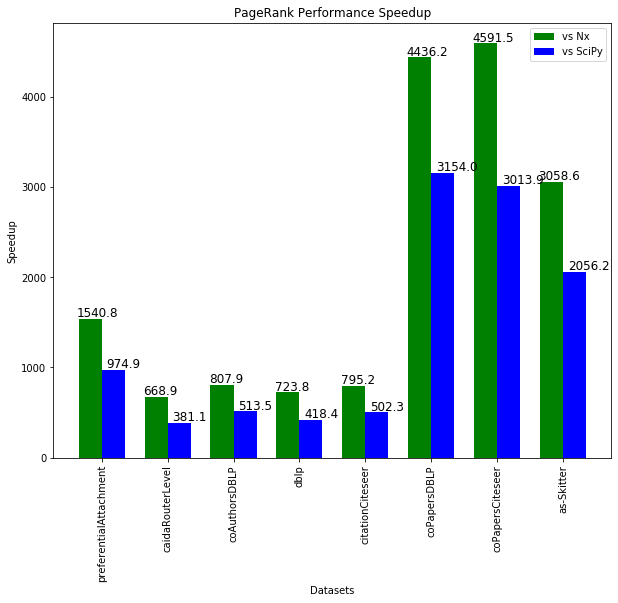

In [10]:
%matplotlib inline

plt.figure(figsize=(10,8))

bar_width = 0.35
index = np.arange(len(names))

_ = plt.bar(index, perf_nx, bar_width, color='g', label='vs Nx')
_ = plt.bar(index + bar_width, perf_sp, bar_width, color='b', label='vs SciPy')

plt.xlabel('Datasets')
plt.ylabel('Speedup')
plt.title('PageRank Performance Speedup')
plt.xticks(index + (bar_width / 2), names)
plt.xticks(rotation=90) 

# Text on the top of each barplot
for i in range(len(perf_nx)):
    plt.text(x = (i - 0.55) + bar_width, y = perf_nx[i] + 25, s = round(perf_nx[i], 1), size = 12)

for i in range(len(perf_sp)):
    plt.text(x = (i - 0.1) + bar_width, y = perf_sp[i] + 25, s = round(perf_sp[i], 1), size = 12)


plt.legend()
plt.show()